## How to Run

0. Run `make setup-env` or just install `requirements.txt`

1. Place the shrid polygons into the following folder:
```
    📦 data
    ┗ 📂 00_raw
      ┗ 📂 SHRUG
        ┣ 📂 geometries_shrug-v1.5.samosa-open-polygons-shp
```

2. Run `python src/01_preprocess_create_mosaiks_points.py` or `make create-mosaiks-points`

3. For MPC authentication, get your subscription key from [here](https://planetarycomputer.developer.azure-api.net/profile) and run `planetarycomputer configure` in terminal and paste is there. Further instructions [here](https://planetarycomputer.microsoft.com/docs/concepts/sas/#:~:text=data%20catalog.-,planetary%2Dcomputer%20Python%20package,-The%20planetary%2Dcomputer).

3. Change the `DATA_ROOT` path to match your system and run this notebook.

#### To Do:
- Figure out sizing of images
- Can we go older than 2013?

In [33]:
import warnings
import os
import gc

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import geopandas as gpd
import dask_geopandas as dask_gpd
from dask.distributed import Client

import matplotlib.pyplot as plt

In [34]:
from custom.mpc_imagery import (
    sort_by_hilbert_distance, 
    filter_points_with_buffer,
    fetch_least_cloudy_stac_items, 
    CustomDataset
)
from custom.models import featurize, RCF

In [35]:
warnings.filterwarnings(action="ignore", category=RuntimeWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)

In [36]:
RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

In [37]:
DATA_ROOT = "/home/jovyan/ds_nudge_up/data/"

## Load point coordinates to fetch images for

Load latlons from file and convert to GeoDataFrame

In [38]:
points_df = pd.read_csv(f"{DATA_ROOT}01_preprocessed/mosaiks_request_points/INDIA_SHRUG_request_points.csv")
points_gdf = gpd.GeoDataFrame(
    points_df, 
    geometry=gpd.points_from_xy(
        points_df['lon'], 
        points_df['lat']
    ),
    crs="EPSG:4326"
)
del points_df

print(points_gdf.shape[0])

96167


In [39]:
points_gdf = sort_by_hilbert_distance(points_gdf)

In [40]:
# for testing, limit to 10 points
points_gdf = points_gdf.sample(10, random_state=0)

<AxesSubplot:>

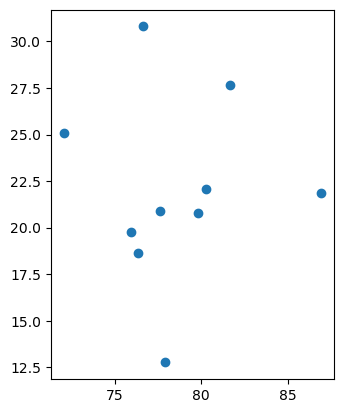

In [41]:
points_gdf.plot()

Convert to DaskGeoDataFrame for parallelization

In [9]:
NPARTITIONS = 250
points_dgdf = dask_gpd.from_geopandas(points_gdf, npartitions=NPARTITIONS, sort=False)

del points_gdf
gc.collect()

110

## Get the imagery around each point

Get stac_item references to the least cloudy image that corresponds to each point

In [10]:
with Client(n_workers=16) as client:
    print(client.dashboard_link)

    # `meta` is the expected output format:
    # an empty df with correct column types
    meta = points_dgdf._meta
    meta = meta.assign(stac_item=pd.Series([], dtype="object"))

    points_gdf_with_stac = points_dgdf.map_partitions(
        fetch_least_cloudy_stac_items, 
        satellite="landsat-8-c2-l2",
        search_start="2013-01-01",
        search_end="2013-12-31",
        meta=meta)

    points_gdf_with_stac = points_gdf_with_stac.compute()

/user/amirali1376@gmail.com/proxy/8787/status


Filter out points with no image found

In [11]:
points_gdf_with_stac_clean = points_gdf_with_stac.dropna(subset=["stac_item"])
matched_stac_items = points_gdf_with_stac_clean.stac_item.tolist()
matched_points_list = points_gdf_with_stac_clean[["lon", "lat"]].to_numpy()

In [12]:
NUM_POINTS = len(points_gdf_with_stac_clean)

Setup Dataset object

In [13]:
BUFFER_DISTANCE = 0.005
bands = [
    # "SR_B1", # Coastal/Aerosol Band (B1)
    "SR_B2",  # Blue Band (B2)
    "SR_B3",  # Green Band (B3)
    "SR_B4",  # Red Band (B4)
    "SR_B5",  # Near Infrared Band 0.8 (B5)
    "SR_B6",  # Short-wave Infrared Band 1.6 (B6)
    "SR_B7",  # Short-wave Infrared Band 2.2 (B7)
]
resolution = 30

dataset = CustomDataset(
    matched_points_list, 
    matched_stac_items, 
    buffer=BUFFER_DISTANCE,
    bands=bands,
    resolution=resolution
)

Setup PyTorch DataLoader

In [14]:
batch_size = 1 # increase this?

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=os.cpu_count(), # AWS can handle *2 since 32GB ram
    collate_fn=lambda x: x,
    pin_memory=False,
    persistent_workers=True,
)

Inspect images

In [15]:
# for images in dataloader:
#     for image in images:
#         # print(image)
#         array = np.array(image[0][:3])
#         reshaped_array = np.swapaxes(array, 0, 2)
#         plt.imshow(reshaped_array)
#         plt.show()

Clear memory

In [16]:
del points_gdf_with_stac
del points_gdf_with_stac_clean
del matched_stac_items
# del matched_points_list
gc.collect()

3221

## Define featurization model and apply to images

In [17]:
NUM_FEATURES = 1024

In [18]:
DEVICE = torch.device("cuda") # change to "cuda" when using GPU
MODEL = RCF(NUM_FEATURES).eval().to(DEVICE)

### Apply featurization to images

In [19]:
min_image_edge = 6

In [20]:
x_all = np.zeros((NUM_POINTS, NUM_FEATURES), dtype=float)

i = 0
for images in tqdm(dataloader):
    for image in images:

        if image is not None:
            # A full image should be 36x36(?) pixels (i.e. ~1km^2 at a 30m/px spatial
            # resolution), however we can receive smaller images if an input point
            # happens to be at the edge of a scene. To deal with these we crudely 
            # drop all images where the spatial dimensions aren't both greater than 6 pixels.
            if image.shape[2] >= min_image_edge and image.shape[3] >= min_image_edge:
                mosaiks_features = featurize(image, MODEL, DEVICE)
                x_all[i] = mosaiks_features
            else:
                pass
        else:
            pass  # this happens if we do have not found an image for some point
        i += 1

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
x_all.shape

(10, 1024)

### Convert to DF and add latlons

In [45]:
column_names = [str(i) for i in range(NUM_FEATURES)]
x_all_df = pd.DataFrame(x_all, columns=column_names)
x_all_df.insert(0, "lat", matched_points_list[:, 1])
x_all_df.insert(1, "lon", matched_points_list[:, 0])

Drop NaNs

In [46]:
x_all_df_clean = x_all_df.dropna()
x_all_df_clean.shape

(7, 1026)

### Save to file (parquet)

In [47]:
output_path = DATA_ROOT+"/01_preprocessed/mosaiks_features/"
os.makedirs(output_path, exist_ok=True)

filename = "mosaiks_2013_landsat8_10points"
x_all_df_clean.to_parquet(output_path+filename+".parquet")

In [29]:
# filename = "2013_latlons_10points.csv"
# np.savetxt(output_path+filename+".csv", matched_points_list, delimiter=",")
# filename = "2013_x_all_10points.csv"
# np.savetxt(output_path+filename+".csv", x_all, delimiter=",")